In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# America house data

## Load dataset

In [50]:
data = fetch_california_housing()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseVal')

## visulaize data

In [51]:
data_combined = pd.concat([X, y], axis=1)
data_combined.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Histograms for data

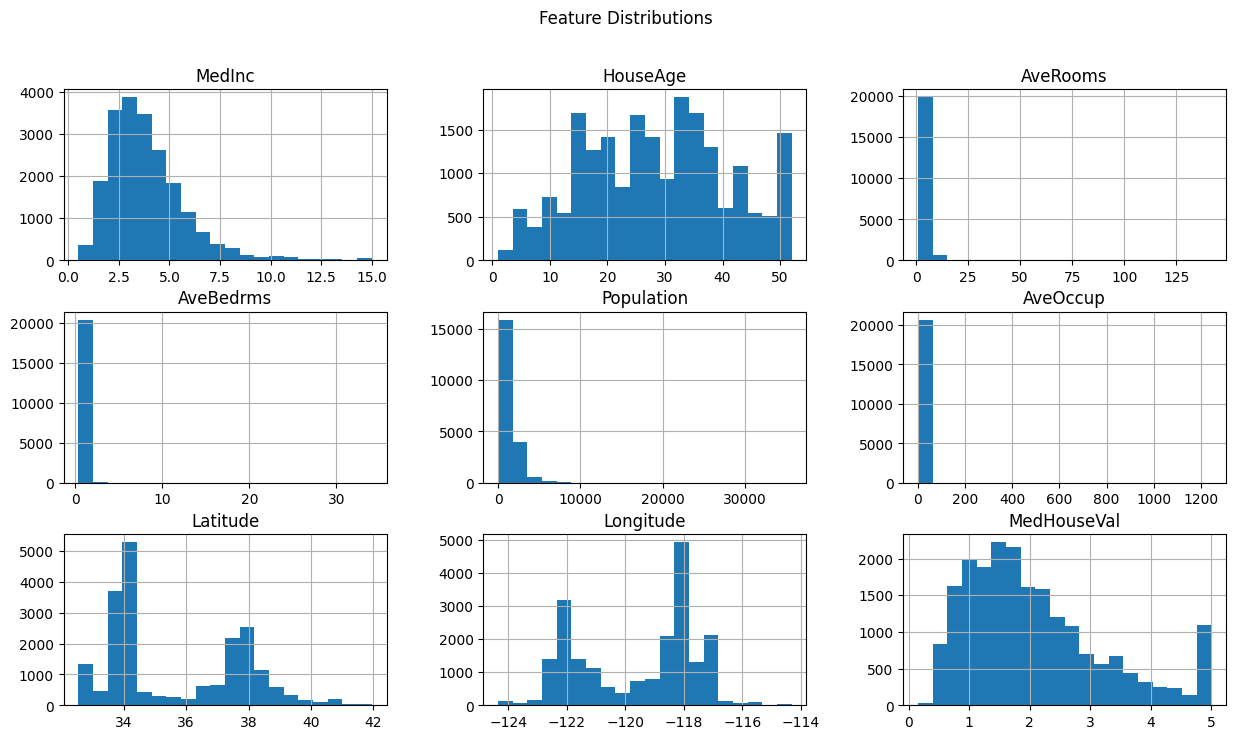

In [22]:
data_combined.hist(bins=20, figsize=(15, 8))
plt.suptitle('Feature Distributions')
plt.show()

## Pairplot

In [23]:
sns.pairplot(data_combined, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Features and Target Variable', y=1.02)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Heatmap

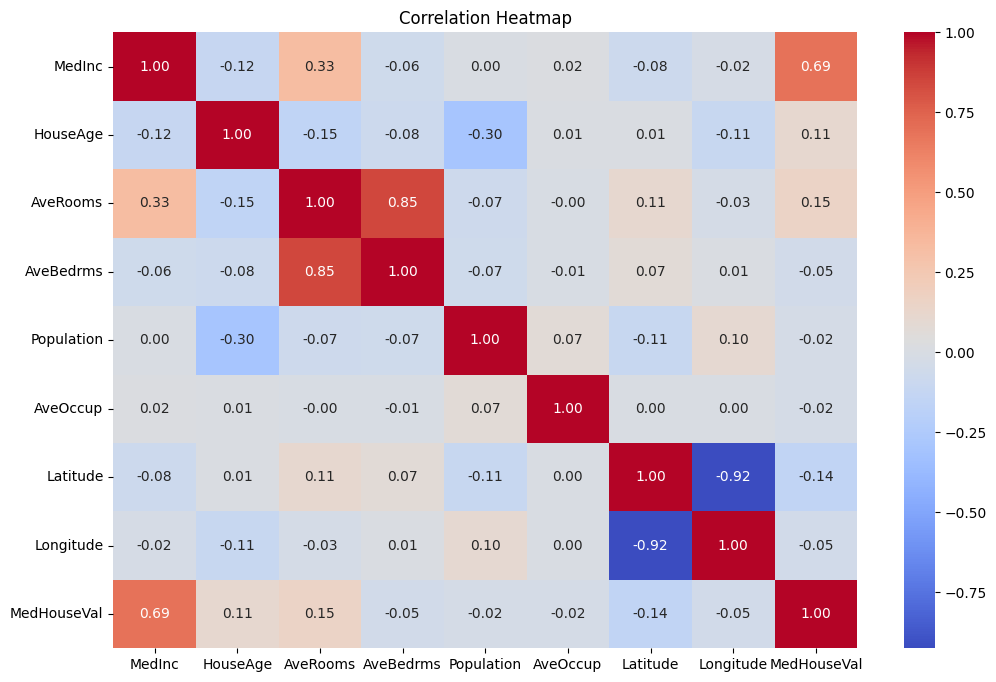

In [24]:
# Compute correlation matrix
corr_matrix = data_combined.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Scatter plots for each feature against the target variable

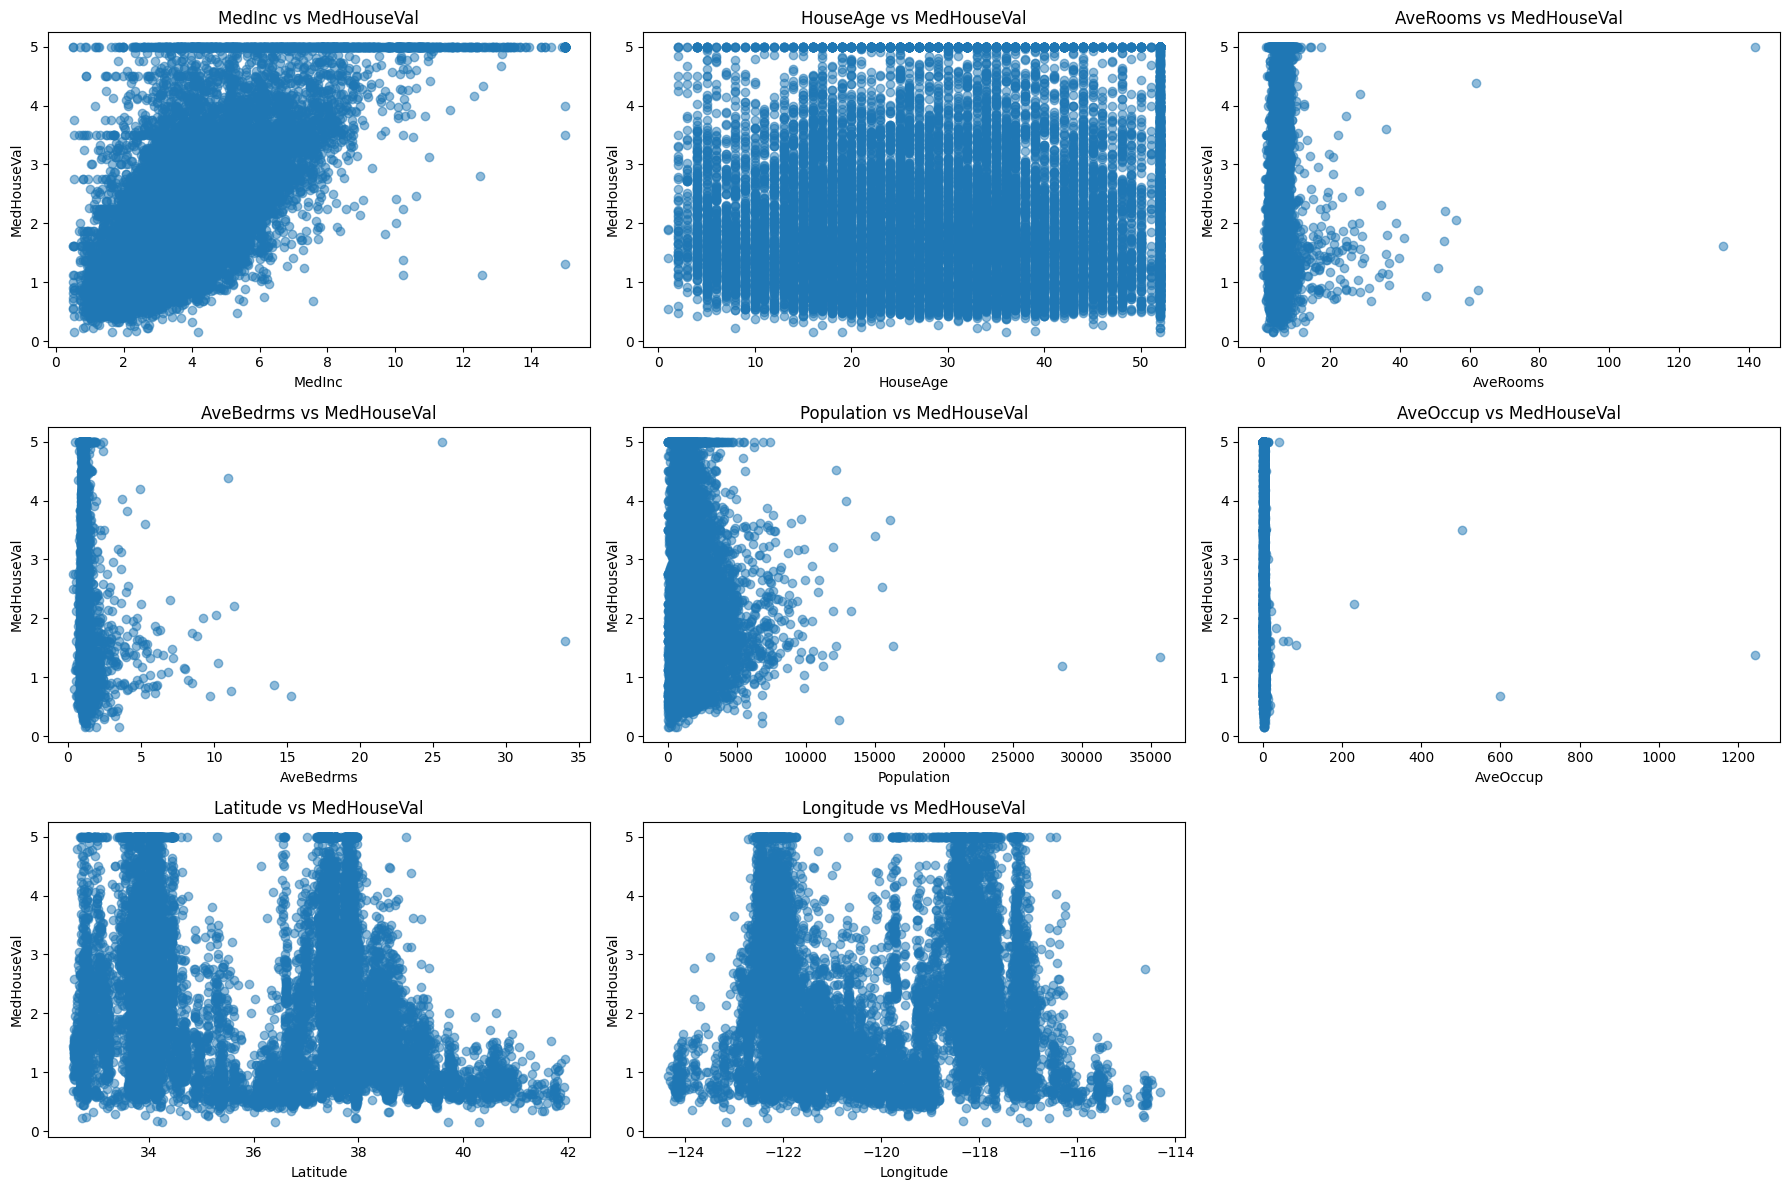

In [29]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Scatter plots for each feature against the target variable
for i, feature in enumerate(X.columns):
  axes[i].scatter(X[feature], y, alpha=0.5)
  axes[i].set_title(f'{feature} vs MedHouseVal')
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel('MedHouseVal')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Split data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model

## Define the parameter grid

In [53]:
param_grid = {
  'n_estimators': [50, 100, 200],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [3, 5, 7]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
  estimator=xgb.XGBRegressor(objective='reg:squarederror'),
  param_grid=param_grid,
  scoring='neg_mean_squared_error',
  cv=3,
  verbose=1
)

## Perform grid search

In [54]:
grid_search.fit(X_train, y_train)

# Get the results
results = pd.DataFrame(grid_search.cv_results_)
results.head()

Fitting 3 folds for each of 27 candidates, totalling 81 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.084938,0.012272,0.010861,0.001333,0.01,3,50,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.871227,-0.852915,-0.875035,-0.866392,0.009656,27
1,0.125642,0.008485,0.011226,0.000352,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.661038,-0.650646,-0.669324,-0.660336,0.007642,24
2,0.222502,0.009234,0.015280,0.000363,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.485152,-0.478790,-0.498709,-0.487550,0.008307,21
3,0.140963,0.001531,0.010737,0.000212,0.01,5,50,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.794311,-0.774162,-0.800386,-0.789619,0.011208,26
4,0.259418,0.015360,0.015630,0.001000,0.01,5,100,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.553875,-0.544425,-0.564408,-0.554236,0.008162,23


## performance heatmap

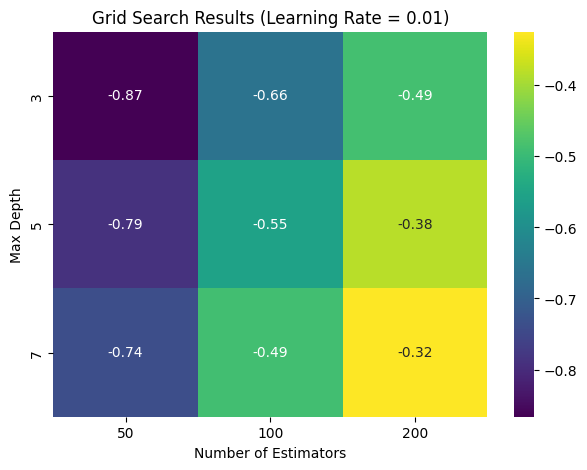

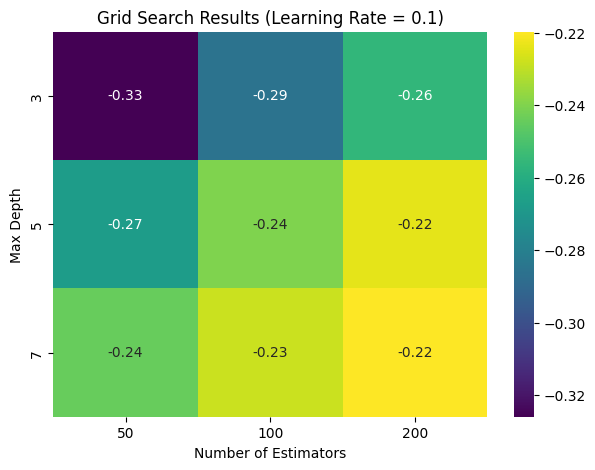

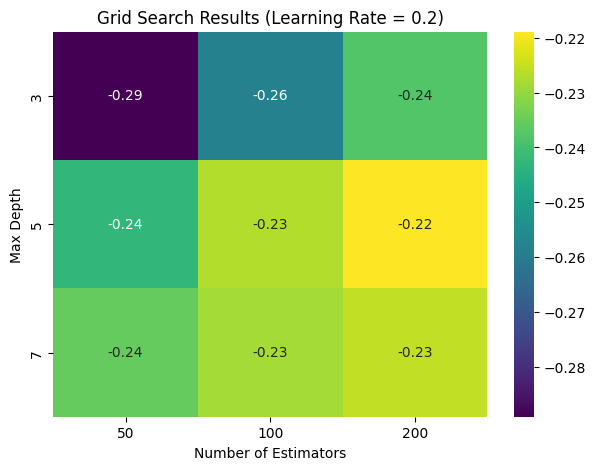

In [43]:
# Function to plot heatmap for a given learning rate
def plot_heatmap_for_learning_rate(learning_rate):
    filtered_results = results[results['param_learning_rate'] == learning_rate]
    pivot_table = filtered_results.pivot_table(
      values='mean_test_score',
      index='param_max_depth',
      columns='param_n_estimators'
    )
    plt.figure(figsize=(7, 5))
    sns.heatmap(pivot_table, annot=True, cmap='viridis')
    plt.title(f'Grid Search Results (Learning Rate = {learning_rate})')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Max Depth')
    plt.show()

# Plot heatmaps for each learning rate
for lr in param_grid['learning_rate']:
    plot_heatmap_for_learning_rate(lr)

## Model training

In [56]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Model evaluation

## Test set prediction

In [57]:
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.4582019876175601


## Learning curve

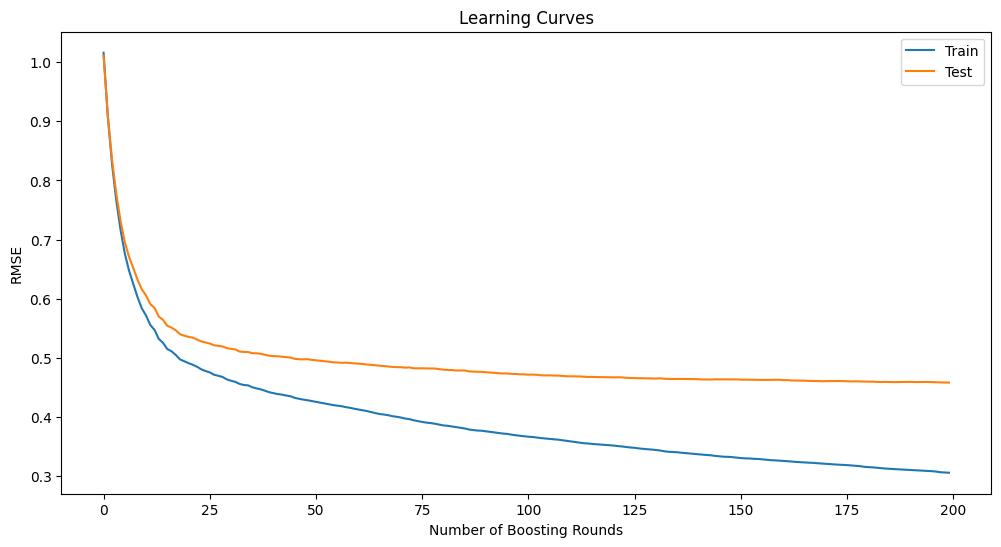

In [58]:
results = model.evals_result()

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

## Plot feature importance

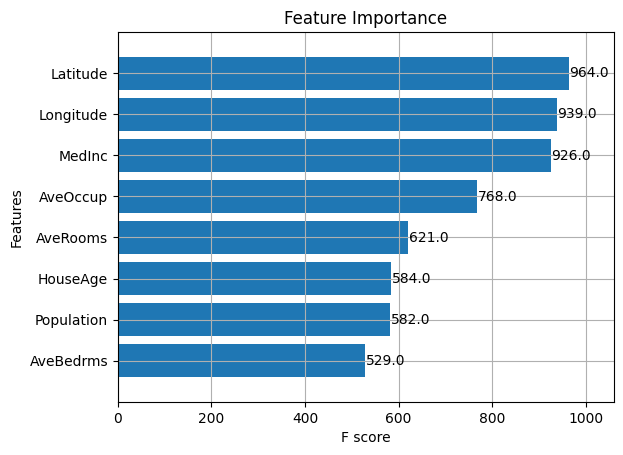

In [59]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.8)
plt.title('Feature Importance')
plt.show()

## Predicted vs Actual Values

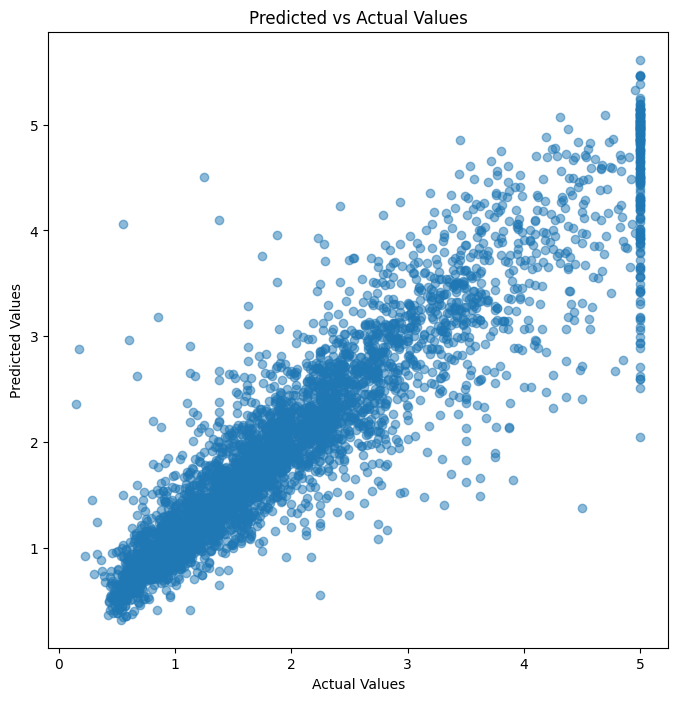

In [61]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()